In [21]:
from functools import partial
from typing import (
  Tuple, List, Dict, Any, Sequence, Callable)

import haiku as hk
import jax
import jax.numpy as jnp
import jax.random as jr 
import jraph
import optax
import numpy as np
import matplotlib.pyplot as plt

In [22]:
from get_mnist import load_mnist
from mnist_to_graphs import (
  get_mnist_graphs, 
  get_rotated_mnist_graphs,
  pad_graph_to_nearest_power_of_two, 
  pad_graph_to_value,
  print_graph)

#### globals

In [23]:
Array = jnp.ndarray
Graph = jraph.GraphsTuple

N_GRAPHS = 1024
BATCH_SIZE = 16
N_STEPS = 5_000
PAD_VALUE = 8128 
R_LINK = 0.15 #2. #1.5
F = 8
E = 8

#### model

##### resnet

In [24]:
class LinearResNet(hk.Module):
  def __init__(
    self, 
    hidden_sizes: Sequence[int],
    activation: Callable = jax.nn.leaky_relu,
    activate_final: bool = False):
    super().__init__()
    self.hidden_sizes = hidden_sizes
    self.activation = activation
    self.activate_final = activate_final

  def __call__(self, x):
    # assert x.shape[-1] == self.hidden_size, (
    #   "Input must be hidden size.")
    z = x
    for f in self.hidden_sizes:
      h = self.activation(z)
      h = hk.LayerNorm(axis=1, create_scale=True, create_offset=True)(h)
      h = hk.Linear(f)(h)
      h = self.activation(h)
      h = hk.LayerNorm(axis=1, create_scale=True, create_offset=True)(h)
      h = hk.Linear(f, w_init=jnp.zeros)(h)
      z = z + h 
    return self.activation(z) if self.activate_final else z

##### gnn

In [25]:
@jraph.concatenated_args
def edge_update_fn(feats: Array) -> Array:
  """ Edge update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F])])
    # hk.Linear(F), hk.nets.MLP([F, F, F])])
  return net(feats)

@jraph.concatenated_args 
def node_update_fn(feats: Array) -> Array:
  """ Node update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F])])
    # hk.Linear(F), hk.nets.MLP([F, F, F])])
  return net(feats)

@jraph.concatenated_args
def update_global_fn(feats: Array) -> Array:
  """ Global update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), 
    #LinearResNet([F, F, F], activate_final=True),
    hk.nets.MLP([F, F, F], activate_final=True),
    hk.Linear(10, with_bias=False)]) # output MNIST classes
  return net(feats)

def LayerNormLinear(x):
    return hk.Linear(E, with_bias=False)(hk.LayerNorm(axis=1, create_offset=True, create_scale=True)(x))

def net_fn(graph: Graph) -> Graph:
  """ 
    Default aggregator functions for edges, global edges, global nodes 
    are "segment_sum"
  """
  embedder = jraph.GraphMapFeatures(
    embed_edge_fn=LayerNormLinear, #hk.Linear(E, with_bias=False), 
    embed_node_fn=LayerNormLinear, #hk.Linear(E, with_bias=False), 
    embed_global_fn=LayerNormLinear) #hk.Linear(E, with_bias=False))
  net = jraph.GraphNetwork(
    update_node_fn=node_update_fn,
    update_edge_fn=edge_update_fn,
    update_global_fn=update_global_fn)
  graph = embedder(graph)
  for _ in range(3):
    graph = net(graph)
  return graph
  #return net(embedder(graph)) 

#### train

(60000, 28, 28, 1) (60000, 1)


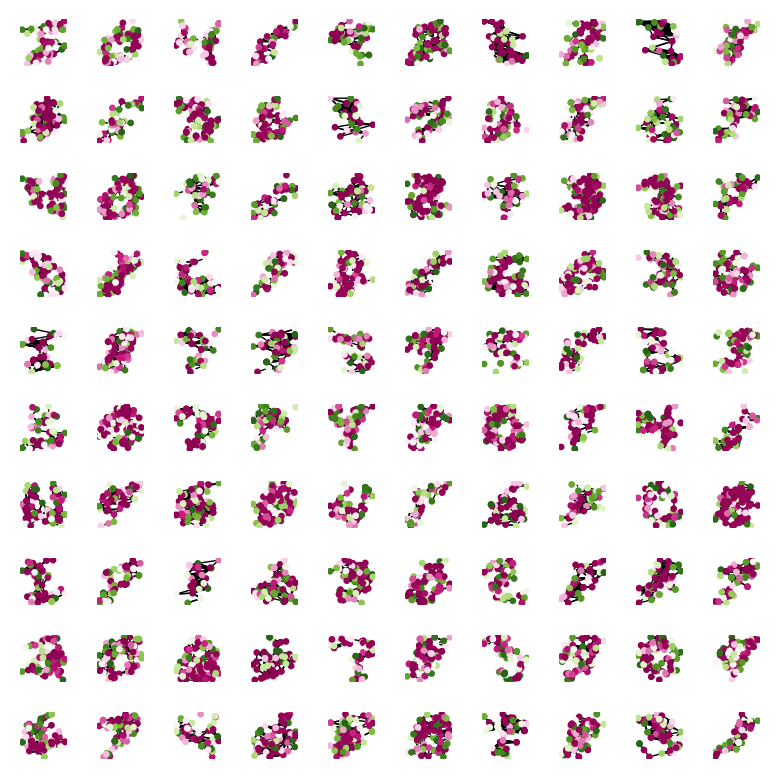

139 1279


In [26]:
X, Y = load_mnist()

print(X.shape, Y.shape)

dataset = get_mnist_graphs(
    X, Y, n_graphs=N_GRAPHS, plot=True, r_link=R_LINK)

print(
    max([g["input_graph"].nodes.shape[0] for g in dataset]),
    max([g["input_graph"].edges.shape[0] for g in dataset]))

#### trainer functions

In [27]:
def compute_loss(
  params: hk.Params, 
  graph: Graph, 
  label: Array,
  net: Graph) -> Tuple[Array, Array]:
  """Computes loss and accuracy."""

  pred_graph = net.apply(params, graph)
  print("pred graph globals", pred_graph.globals.shape)

  # Output of GNN and target: one hot encoded MNIST labels
  preds = jax.nn.log_softmax(pred_graph.globals)

  mask = jraph.get_graph_padding_mask(pred_graph)

  # Cross entropy loss.
  print("PREDS/TARGETS", preds.shape, label.shape)
  loss = -(preds * label * mask[:, None]).mean()

  # Accuracy taking into account the mask.
  print("pred graph global", pred_graph.globals.argmax(axis=1))#[mask])
  print("label", label.argmax(axis=1))#[mask])

  pred_digit = pred_graph.globals.argmax(axis=1)
  accuracy = (
    (pred_digit == label.argmax(axis=1)) * mask  / mask.sum()
  ).sum()
  return loss, (accuracy, pred_digit )
 

def train(
  dataset: List[Dict[str, Any]], 
  num_train_steps: int) -> Tuple[hk.Params, List, List]:

  key = jr.PRNGKey(0)

  net = hk.without_apply_rng(hk.transform(net_fn))

  graph = dataset[0]['input_graph']
  graph = pad_graph_to_value(graph, PAD_VALUE)
  params = net.init(key, graph)

  print(f"n_params = {sum(x.size for x in jax.tree_util.tree_leaves(params)):.2E}")

  # Initialize the optimizer.
  opt_init, opt_update = optax.adabelief(2e-4)
  opt_state = opt_init(params)

  compute_loss_fn = partial(compute_loss, net=net)
  compute_loss_fn = jax.jit(
    jax.value_and_grad(compute_loss_fn, has_aux=True))

  losses, accs = [], []
  for _ in range(num_train_steps):
    key, key_idx = jr.split(key)

    if BATCH_SIZE > 1:
        idx = jr.randint(key_idx, shape=(BATCH_SIZE,), minval=0, maxval=N_GRAPHS)
        gs, ls = [], []
        for i in idx:
            g, l = dataset[int(i)].values()
            gs.append(g), ls.append(l)
        graph = jraph.batch(gs)
        label = jnp.concatenate(ls)
    else:
        idx = int(jr.randint(key_idx, shape=(BATCH_SIZE,), minval=0, maxval=N_GRAPHS))
        graph, label = dataset[idx].values()

    """ Should remove graph label, for model to generate itself. """
    # graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
    graph = pad_graph_to_value(graph, PAD_VALUE)

    # Since padding is implemented with pad_with_graphs, an extra graph has
    # been added to the batch, which means there should be an extra label.
    """ This label gets masked out. """
    label = jnp.concatenate([label, jnp.zeros((1, 10))])

    (loss, (acc, pred)), grad = compute_loss_fn(params, graph, label)
    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)

    if _ % 100 == 0:
      print(f'\rstep: {_:06d}, ' +
            f'loss: {loss:.4f}, ' + 
            f'acc: {100. * acc:.4f} ' + 
            f'l: {label.argmax(axis=1)} ' +
            f'l_: {pred}', end="")
    losses.append(loss)
    accs.append(acc)

  print('Training finished')
  return params, losses, accs


def evaluate(
  dataset: List[Dict[str, Any]],
  params: hk.Params) -> Tuple[Array, Array]:

  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn))

  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  accumulated_loss = 0.
  accumulated_accuracy = 0.

  compute_loss_fn = jax.jit(partial(compute_loss, net=net))
  for idx in range(len(dataset)):
    graph = dataset[idx]['input_graph']
    label = dataset[idx]['target']

    graph = pad_graph_to_value(graph, PAD_VALUE)
    label = jnp.concatenate([label, jnp.zeros_like(label)])

    graph = net.apply(params, graph)

    print("label", label.argmax(axis=1), graph.globals.argmax(axis=1))

    loss, acc = compute_loss_fn(params, graph, label)

    accumulated_accuracy += acc
    accumulated_loss += loss

    if idx % 100 == 0:
      print(f'Evaluated {idx + 1} graphs')

  print('Completed evaluation.')
  loss = accumulated_loss / idx
  accuracy = accumulated_accuracy / idx
  print(f'Eval loss: {loss:.4f}, accuracy {accuracy:.4f}')
  return loss, accuracy

#### check

In [28]:
key = jr.PRNGKey(0)

# Want to predict 'l' which is same as g.globals,
# so remove g.globals before input to GNN
g = dataset[0]["input_graph"]
l = dataset[0]["target"]

print(g.globals, l)

dataset_processed = []
for _ in range(len(dataset)):
    g, l = dataset[_]["input_graph"], dataset[_]["target"]
    # Replace global with a zero (model doesn't get true label)
    g = g._replace(globals=jnp.zeros((1, 10)))
    # Scale node information and 
    g = g._replace(nodes=g.nodes / 255.)
    # Replace target with 
    l = hk.one_hot(l, 10)
    dataset_processed.append(dict(input_graph=g, target=l))

dataset_processed[0]["input_graph"].globals

[[5.]] [5.]


DeviceArray([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [35]:
gs, ls = [], []
for _ in range(5):
    gl = dataset_processed[_]
    g, l = gl.values()
    print(g.globals.shape)
    gs.append(g), ls.append(l)

g_all = jraph.batch(gs)
print([g.nodes.shape for g in gs])
g_all.nodes.shape
g_all.n_node

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
[(83, 1), (88, 1), (60, 1), (48, 1), (71, 1)]


DeviceArray([83, 88, 60, 48, 71], dtype=int32)

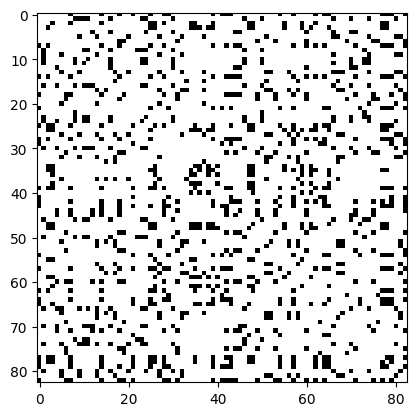

In [30]:
def adjacency_matrix(sender_indices, receiver_indices, n_nodes=None):
    # Determine the number of nodes in the graph if not provided
    if n_nodes is None:
        n_nodes = max(max(sender_indices), max(receiver_indices)) + 1

    # Create an empty adjacency matrix
    adj_matrix = np.zeros((n_nodes, n_nodes))

    # Set entries in the adjacency matrix for each edge
    for sender, receiver in zip(sender_indices, receiver_indices):
        # Set both: undirected graph!
        adj_matrix[sender, receiver] = 1 
        adj_matrix[receiver, sender] = 1 

    return adj_matrix

g = dataset_processed[0]["input_graph"]
s, r = g.senders, g.receivers
plt.imshow(adjacency_matrix(s, r), cmap="gray_r")

In [31]:
hk.one_hot(jnp.array([5.]), 10)

DeviceArray([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [32]:
key, _ = jr.split(key)

net = hk.without_apply_rng(hk.transform(net_fn))

ix1, ix2 = jr.randint(key, (2,), 0, len(dataset_processed))

graph = dataset_processed[ix1]['input_graph']
l = dataset_processed[ix1]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)
print(graph.globals)

print(graph.globals)

params = net.init(key, graph)

graph = dataset_processed[ix2]['input_graph']
l = dataset_processed[ix2]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)

y_ = net.apply(params, graph)
print("net out", y_.globals.shape)

mask = jraph.get_graph_padding_mask(y_)
print(mask)

jnp.argmax(y_.globals[mask], axis=1), l.argmax()

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
net out (2, 10)
[ True False]


(DeviceArray([6], dtype=int32), DeviceArray(4, dtype=int32))

In [33]:
graph = dataset_processed[ix2]['input_graph']
print("before pad", graph.nodes.shape, graph.edges.shape, graph.globals.shape)
l = dataset_processed[ix2]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)
print("after pad", graph.nodes.shape, graph.edges.shape, graph.globals.shape)

before pad (82, 1) (512, 3) (1, 10)
after pad (8129, 1) (8128, 3) (2, 10)


In [34]:
params, losses, accs = train(dataset_processed, num_train_steps=N_STEPS)

n_params = 6.48E+03
pred graph globals (17, 10)
PREDS/TARGETS (17, 10) (17, 10)
pred graph global Traced<ShapedArray(int32[17])>with<DynamicJaxprTrace(level=0/1)>
label Traced<ShapedArray(int32[17])>with<DynamicJaxprTrace(level=0/1)>


2023-05-12 16:17:28.245615: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 37m48.683646s

********************************
[Compiling module jit__unnamed_function_] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


step: 000000, loss: 4342.1328, acc: 0.0000 l: [4 2 9 7 2 7 9 9 2 4 2 4 4 6 0 7 0] l_: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0]

RuntimeError: Given graph is too large for the given padding. difference: n_node 6892, n_edge -759, n_graph 1

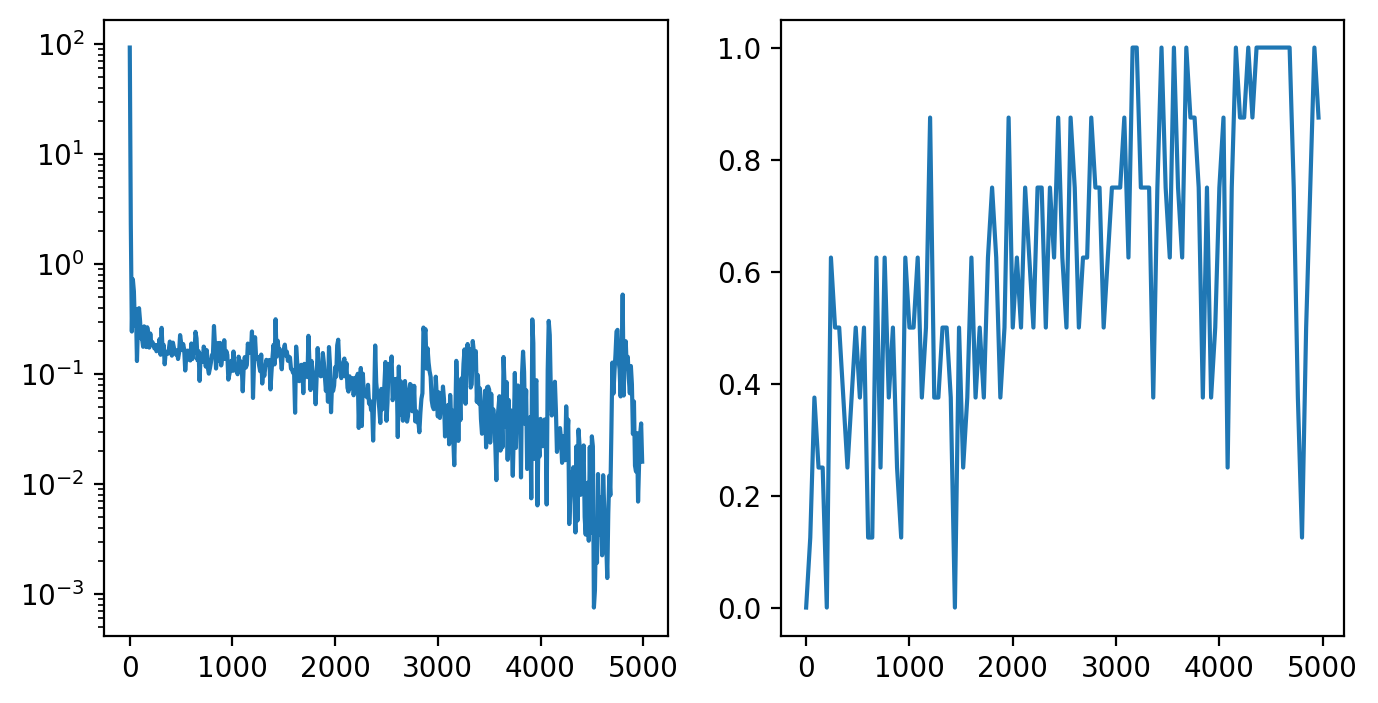

In [ ]:
fig, axs = plt.subplots(1, 2, dpi=200, figsize=(8.,4.))
ax = axs[0]
steps = range(0, N_STEPS, 10)
ax.semilogy(steps, losses[::10])
ax = axs[1]
steps = range(0, N_STEPS, 40)
ax.plot(steps, accs[::40])
plt.show()

In [ ]:
evaluate(dataset_processed, params)

label [5 0] [8 9]


ValueError: 'linear_1/w' with retrieved shape (1, 32) does not match shape=[32, 32] dtype=dtype('float32')

In [ ]:
c, n = 0, 0
total_accuracy = 0.
for _ in range(len(dataset)):

    x = dataset_processed[_]["input_graph"]
    label = dataset_processed[_]["target"]
    #x = pad_graph_to_nearest_power_of_two(x)
    x = pad_graph_to_value(x, PAD_VALUE)
    # label = jnp.concatenate([label, jnp.array([0])])

    y_ = net.apply(params, x)
    mask = jraph.get_graph_padding_mask(y_)

    accuracy = jnp.sum(     
        (jnp.argmax(y_.globals, axis=1) == label) * mask) / jnp.sum(mask)
    print(f"{jnp.argmax(y_.globals, axis=1)[0]} {int(dataset[_]['target'])}")

    total_accuracy += accuracy

    total_accuracy /= _
    print(f"ACCURACY = {total_accuracy:.2f}%")

    # Try rotating the graph to test invariance of classification
    print("TESTING ROTATION INVARIANCE.")
    key = jr.PRNGKey(1294)
    n_test = 10
    ix = jr.randint(key, shape=(n_test,), minval=0, maxval=n_test)
    dataset = get_rotated_mnist_graphs(
    X[ix], Y[ix], n_graphs=n_test, r_link=R_LINK, plot=True)

    for i in range(n_test):
        x, y = dataset_processed[i]["input_graph"], dataset_processed[i]["target"]
        x = pad_graph_to_value(x, PAD_VALUE)
        # label = jnp.concatenate([y, jnp.array([0])])

        y_ = net.apply(params, x)
        mask = jraph.get_graph_padding_mask(y_) 

        # accuracy = jnp.sum(     
        #     (jnp.argmax(y_.globals, axis=1) == y) * mask) / jnp.sum(mask)

        # no mask, globals stay same size always?
        accuracy = jnp.sum(jnp.argmax(y_.globals, axis=1) == y) 
        print(f"{jnp.argmax(y_.globals, axis=1)[0]} {int(dataset[i]['target'])}")

ValueError: Incompatible shapes for broadcasting: shapes=[(2,), (1, 10)]